<a href="https://colab.research.google.com/github/CalvinXKY/InfraTech/blob/main/deeplearning_framework/mini_dl_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 迷你版深度学习框架实践
Mini Deep Learning Framework Practice

Author: kaiyuan

Email: kyxie@zju.edu.cn

## 1 定义Tensor



要求：
* Tensor类存储：数值val、梯度grad、上游节点信息
* tensor.backward()能够触发自动梯度求解。
* 定义常用的tensor操作+、-、*，包括forward、backward函数。

In [ ]:
class Tensor:
    """ stores a single scalar Tensor and its gradient """

    def __init__(self, val, _children=(), _op=''):
        self.val = val
        self.grad = 0
        self._backward = lambda: None  # 用于构建自动梯度图
        self._prev = set(_children)  # 图关系中的上游节点
        self._op = _op # 辅助变量，用于graphviz、debugging、etc


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.val + other.val, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.val * other.val, (self, other), '*')

        def _backward():
            self.grad += other.val * out.grad
            other.grad += self.val * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Tensor(self.val**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.val**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Tensor(0 if self.val < 0 else self.val, (self,), 'ReLU')

        def _backward():
            self.grad += (out.val > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Tensor(val={self.val}, grad={self.grad})"

用简单例子测试tensor类的功能

In [ ]:
x = Tensor(-2.0)
z = 2 * x
y1 = z + 5
y2 = (z * z).relu() + x + 3
loss = y1 - y2 + y2 * x
loss.backward()

print(f"x: {x.val}   x.grad: {x.grad}")
print(f"z: {z.val}   z.grad: {z.grad}")
print(f"y1: {y1.val}  y1.grad: {y1.grad}")
print(f"y2: {y2.val}  y2.grad: {y2.grad}")

x: -2.0   x.grad: 64.0
z: -4.0   z.grad: 25.0
y1: 1.0  y1.grad: 1
y2: 17.0  y2.grad: -3.0


用PyTorch校验计算是否正确

In [ ]:
import torch
x = torch.tensor([-2], dtype=torch.float32, requires_grad=True)
z = 2 * x
y1 = z + 5
y2 = (z * z).relu() + x + 3
loss = y1 - y2 + y2 * x
# 保存中间梯度
z.retain_grad()
y1.retain_grad()
y2.retain_grad()
loss.backward()
print("PyTorch computed result:")
print(f"x: {x.item()} x.grad: {x.grad.item()}")
print(f"z: {z.item()} z.grad: {z.grad.item()}")
print(f"y1: {y1.item()} y1.grad: {y1.grad.item()}")
print(f"y2: {y2.item()} y2.grad: {y2.grad.item()}")

PyTorch computed result:
x: -2.0 x.grad: 64.0
z: -4.0 z.grad: 25.0
y1: 1.0 y1.grad: 1.0
y2: 17.0 y2.grad: -3.0


## 2 定义网络中的基本元素



In [ ]:
import random

# 模块基类：
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

# 定义神经元
class Neuron(Module):

    def __init__(self, n_in, nonlinear=True):
        self.w = [Tensor(random.uniform(-1,1)) for _ in range(n_in)]
        self.b = Tensor(0)
        self.nonlinear = nonlinear

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlinear else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlinear else 'Linear'}Neuron({len(self.w)})"

# 定义层
class Layer(Module):

    def __init__(self, n_in, n_out, **kwargs):
        self.neurons = [Neuron(n_in, **kwargs) for _ in range(n_out)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

# 定义MLP模块
class MLP(Module):

    def __init__(self, n_in, n_outs):
        # 举个例子 n_in =2, n_outs=[3, 4, 1]
        # 表示第一层的输入是2输出是3，第二层的输入输出3、4，最后一层输入输出4、1。
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1], nonlinear= i!=len(n_outs)-1) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

定义优化器和loss函数

In [ ]:
# 定义一个SGD优化器：
def SGD(model, learning_rate_decay):
    learning_rate = 1.0 - 0.9*learning_rate_decay/100
    for p in model.parameters():
        p.val -= learning_rate * p.grad

In [ ]:
# 定义loss acc函数
def loss_acc_func(parameters, scores, yb, batch_size=None):
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in parameters))
    total_loss = data_loss + reg_loss

    # acc:
    accuracy = [(yi > 0) == (scorei.val > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [ ]:
from tqdm import tqdm

# 定义训练函数
def train(X, y, model, step=50, batch_size=None):
    """
    训练模型：
    :param X: 输入值
    :param y: 真值
    :param model: 训练模型
    :param step: 训练步数
    :param batch_size: 分批的尺寸
    :return:
    """
    bar = tqdm(range(step), colour="red",  desc=f"Training",  ncols=100)
    for k in bar:
        if batch_size is None:
            Xb, yb = X, y
        else:
            ri = np.random.permutation(X.shape[0])[:batch_size]
            Xb, yb = X[ri], y[ri]
        inputs = [list(map(Tensor, xrow)) for xrow in Xb]

        # forward the model to get scores
        scores = list(map(model, inputs))
        total_loss, acc = loss_acc_func(model.parameters(), scores, yb)

        # backward
        model.zero_grad()
        total_loss.backward()

        # optimizer update
        SGD(model, k)

        bar.set_postfix(loss=total_loss.val, acc=f"{acc*100}%")


# 3 训练MLP网络

In [ ]:
# 创建一个两层的网络
model = MLP(2, [90, 1])
print("number of parameters", len(model.parameters()))

number of parameters 361


## 训练blobs数据集

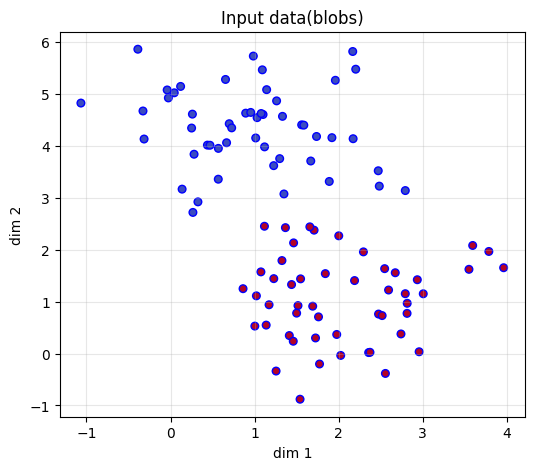

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 固定随机种子，生成相同数据
np.random.seed(0)
random.seed(0)

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=0.8, )

# 将标签数据y 从0,1 转换为 -1,1：
y = y*2 - 1
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, s=30, cmap='coolwarm', edgecolors='b')
plt.title('Input data(blobs)')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 打印2D结果的函数
def plot_result(epoch=1):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Tensor, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.val > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'Classification Result. Epoch={epoch}')

Training: 100%|████████████████████████████| 40/40 [01:00<00:00,  1.51s/it, acc=100.0%, loss=0.0403]


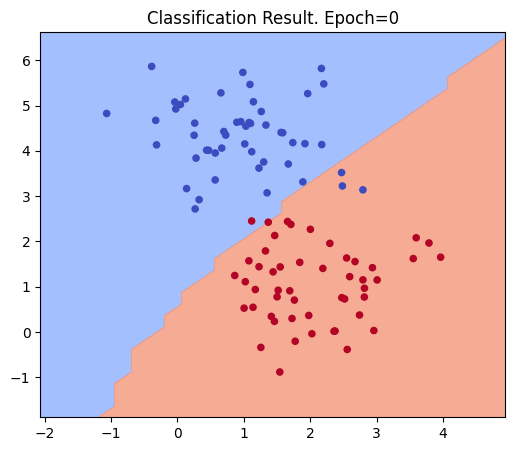

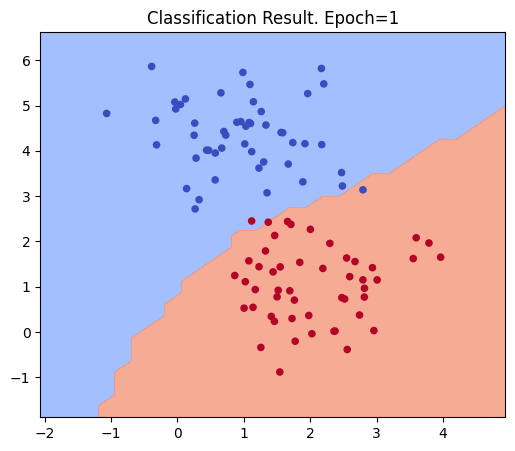

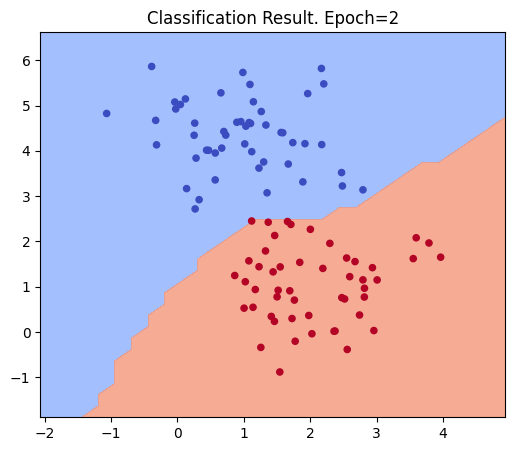

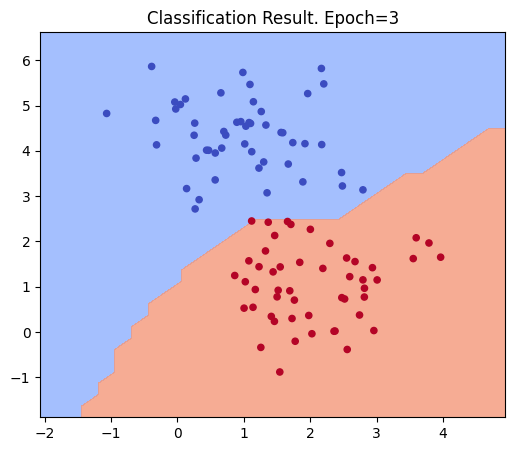

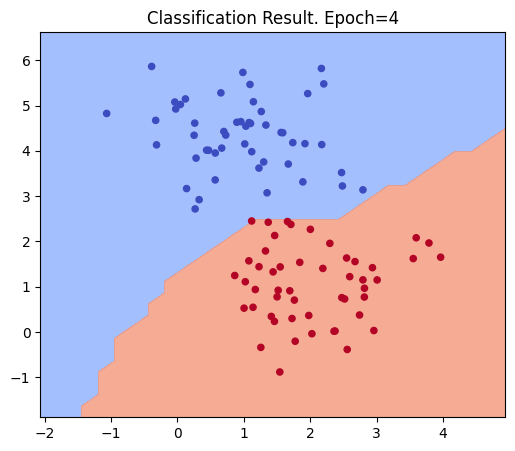

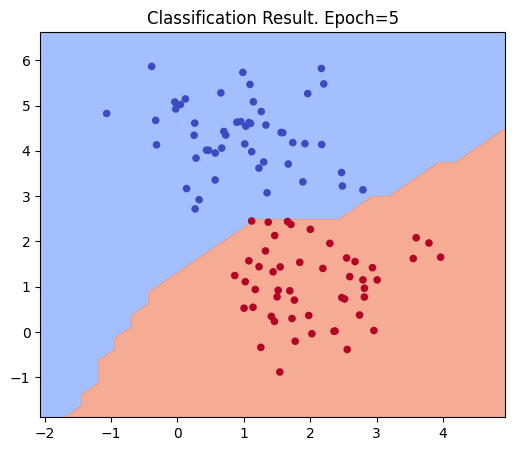

In [ ]:
# 训练6个epoch
for i in range(6):
    train(X, y, model, step=40)
    plot_result(i)

## 训练circles数据集

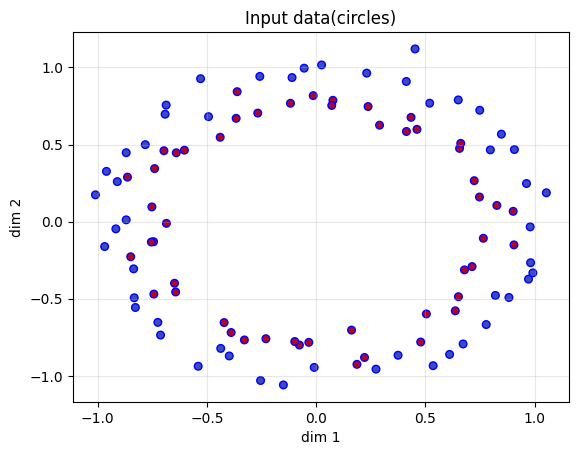

In [ ]:
from sklearn.datasets import make_moons, make_circles
X, y = make_circles(n_samples=100, noise=0.06)

# 将标签数据y 从0,1 转换为 -1,1：
y = y*2 - 1

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=30, cmap='coolwarm', edgecolors='b')
plt.title('Input data(circles)')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 创建一个三层的网络
model = MLP(2, [15, 20, 1])

In [ ]:
# 重新定义绘图
def plot_result(epoch=1):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Tensor, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.val > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'Classification Result. Epoch={epoch}')

Training: 100%|██████████████████████████████| 30/30 [00:59<00:00,  1.97s/it, acc=90.0%, loss=0.249]


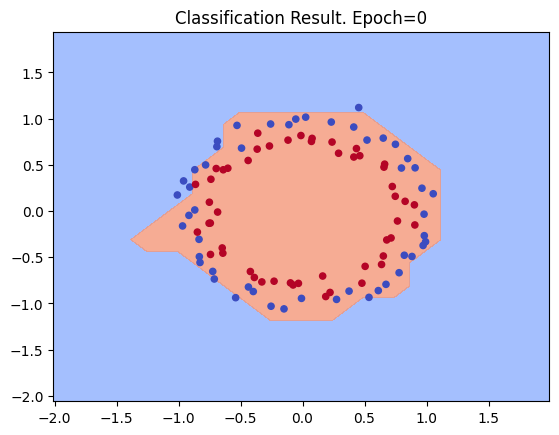

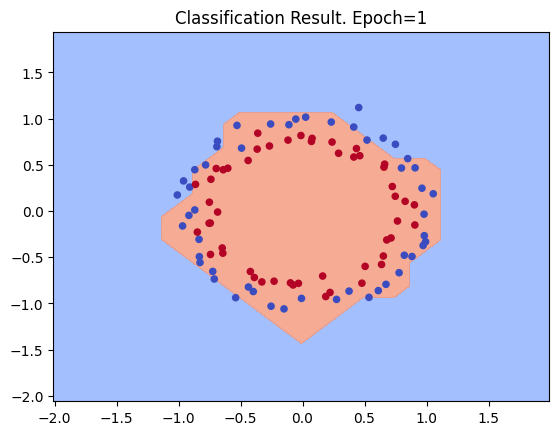

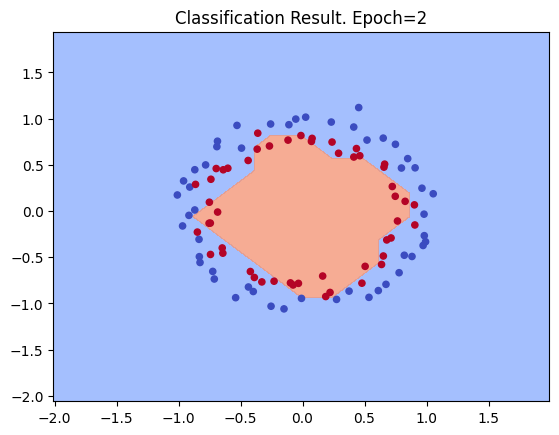

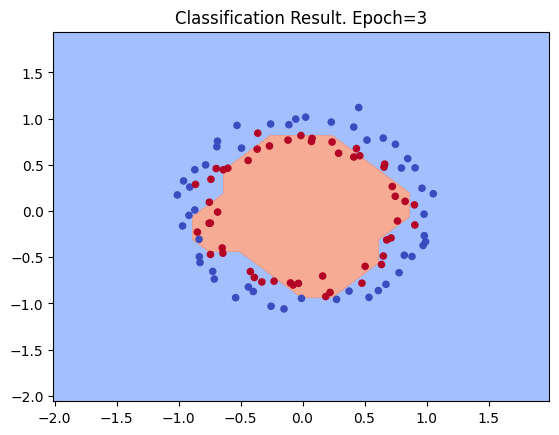

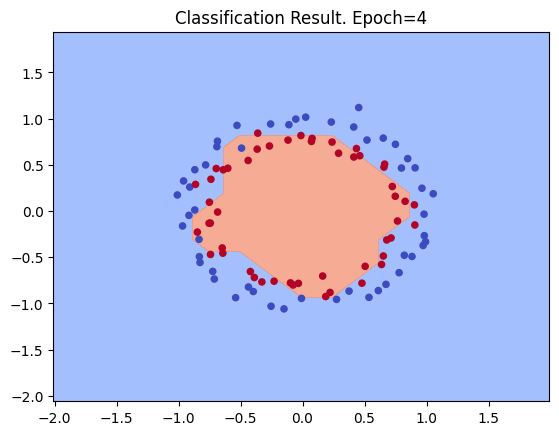

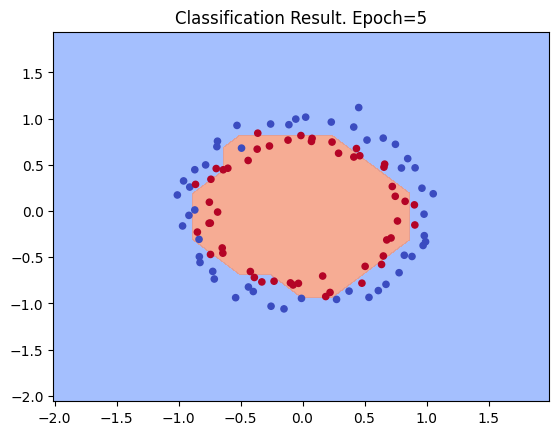

In [ ]:
# 训练并观测结果
for i in range(6):
  train(X, y, model, step=30)
  plot_result(i)

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='TB'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right) 显示方向
    """
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    # dot.graph_attr.update({
    # 'size': '20，18',        # 指定图像尺寸为 8英寸 x 5英寸，感叹号(!)强制按此尺寸渲染
    # 'ratio': 'expand',       # 填充整个尺寸区域，也可用'compress', 'expand', 'auto'
    # })
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.2f |grad %.2f }" % (n.val, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


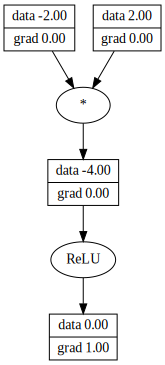

In [ ]:
x = Tensor(-2.0)
z = 2 * x
y = z.relu()
y.backward()
draw_dot(y, rankdir='TB')


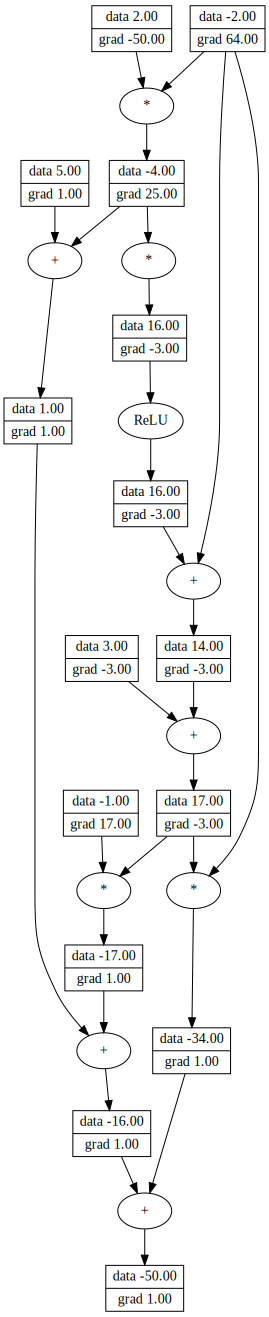

In [ ]:
x = Tensor(-2.0)
z = 2 * x
y1 = z + 5
y2 = (z * z).relu() + x + 3
loss = y1 - y2 + y2 * x
loss.backward()
draw_dot(loss, format='png')

In [ ]:
# 打印层信息：
model = MLP(2, [2, 1])
print(model)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2)], Layer of [LinearNeuron(2)]]
